# Imports and loads

In [1]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores.csv', encoding='utf-8')
print(df05ht.shape)

(434237, 27)


- [ ] Procurar sobre importância de atributos
- [ ] Calcular acurácia dos modelos
- [ ] Fazer previsão por liga

In [2]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_won_home', 'fouls_won_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id'],
      dtype='object')

In [3]:
# pd.set_option('display.max_rows', None)
# display(df05ht[(df05ht['homeTeam'] == 'Grêmio Novorizontino') & (df05ht['awayTeam'] == 'Vancouver Whitecaps FC')])

In [4]:
df05ht

,date,minute,homeTeam,awayTeam,league,corners_home,corners_away,redcards_home,redcards_away,shotsOffgoal_home,...,fouls_c_home,fouls_c_away,fouls_won_home,fouls_won_away,offsides_home,offsides_away,tackles_home,tackles_away,result,match_id
0,2020-01-22,10:26,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2020-01-22-CD San José-Club Guaraní
1,2020-01-22,11:06,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,2020-01-22-CD San José-Club Guaraní
2,2020-01-22,11:45,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
3,2020-01-22,12:25,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,1.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
4,2020-01-22,13:04,CD San José,Club Guaraní,South America - CONMEBOL Libertadores,0.0,0.0,0.0,0.0,1.0,...,2.0,2.0,1.0,1.0,0.0,1.0,0.0,3.0,0.0,2020-01-22-CD San José-Club Guaraní
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434232,2020-10-14,43:27,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,9.0,8.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434233,2020-10-14,44:07,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,10.0,9.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434234,2020-10-14,44:46,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,10.0,9.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales
434235,2020-10-14,45+0:26,Bulgaria,Wales,Europe - UEFA Nations League,1.0,5.0,0.0,0.0,0.0,...,7.0,11.0,10.0,7.0,0.0,2.0,3.0,5.0,0.0,2020-10-14-Bulgaria-Wales


In [5]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2023-11-20 00:00:00


# Preprocessamento dos dados

## Limpeza

In [6]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# Identificando e removendo IDs de jogos com minutos fora do intervalo
invalid_ids = df[df['minute_converted'] > 45]['match_id'].unique()
df = df[~df['match_id'].isin(invalid_ids)]

# Removendo a coluna 'minute_converted' e salvando o DataFrame com o formato original (sem os minutos convertidos)
# df.drop(columns=['minute_converted']).drop_duplicates().to_csv('data_teste.csv', index=False, encoding='utf-8')

df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
print(f'Jogos que serão retirados: {len(invalid_ids)}\n')

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Dimensão do DataFrame antes remoção: (434237, 27)
Valores únicos de minutos antes da conversão: ['10:26' '11:06' '11:45' ... '41:07' '22:60' '17:38'] 

Registros duplicados: 0
Registros nulos: 0

Jogos que serão retirados: 0

Dimensão do DataFrame após remoção: (434237, 27)
Total de registros retirados: 0


In [7]:
# datas com minutos inválidos
datas = df05ht[df05ht['match_id'].isin(invalid_ids)]['date'].unique()
for data in datas:
    print(f"'{data}',", end=' ')

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [8]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)
print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')


Ligas únicas: ['South America - CONMEBOL Libertadores' 'Brazil - Paulista A1'
 'Asia - AFC Champions League' 'Brazil - Supercopa do Brasil'
 'Japan - J1 League' 'South America - CONMEBOL Sudamericana' 'USA - MLS'
 'Brazil - Copa do Brasil' 'Germany - Play-offs 1/2' 'Mexico - Liga MX'
 'Scotland - Premiership' 'Brazil - Serie A' 'France - Ligue 1'
 'Europe - UEFA Champions League' 'England - League Cup'
 'Europe - UEFA Nations League' 'England - Premier League'
 'Germany - Bundesliga' 'Italy - Serie A' 'Italy - Serie B'
 'Netherlands - Eredivisie' 'England - Championship'
 'Spain - Primera División' 'Greece - Super League 1'
 'South America - CONMEBOL World Cup Qualifiers' 'England - League One'
 'England - League Two' 'Europe - UEFA Europa League'
 'Argentina - Liga Profesional Argentina' 'England - FA Cup'
 'Australia - A-League Men' 'Europe - UEFA European Championship'
 'N/C America - Concacaf Gold Cup' 'Europe - UEFA World Cup Qualifiers'
 'Denmark - Superliga' 'Saudi Arabia - Saud

## Tratando o formato das ligas para ligas existentes na API

In [9]:
# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Liga atual: South America - CONMEBOL Libertadores
Liga atual: Brazil - Paulista A1
Liga atual: Asia - AFC Champions League
Liga atual: Brazil - Supercopa do Brasil
Liga atual: Japan - J1 League
Liga atual: South America - CONMEBOL Sudamericana
Liga atual: USA - MLS
Liga atual: Brazil - Copa do Brasil
Liga atual: Germany - Play-offs 1/2
Liga atual: Mexico - Liga MX
Liga atual: Scotland - Premiership
Liga atual: Brazil - Serie A
Liga atual: France - Ligue 1
Liga atual: Europe - UEFA Champions League
Liga atual: England - League Cup
Liga atual: Europe - UEFA Nations League
Liga atual: England - Premier League
Liga atual: Germany - Bundesliga
Liga atual: Italy - Serie A
Liga atual: Italy - Serie B
Liga atual: Netherlands - Eredivisie
Liga atual: England - Championship
Liga atual: Spain - Primera División
Liga atual: Greece - Super League 1
Liga atual: South America - CONMEBOL World Cup Qualifiers
Liga atual: England - League One
Liga atual: England - League Two
Liga atual: Europe - UEFA Eu

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas: 11842

Balanceando dados...
Dados balanceados:

result
0.0    52062
1.0    52062
Name: count, dtype: int64

Filtrando dados de ligas...
Dados filtrados:

league
England - Premier League             8455
USA - Major League Soccer            8305
Brazil - Serie A                     5266
Argentina - Superliga                5257
Spain - La Liga                      4677
Germany - Bundesliga                 4203
England - Championship               3841
England - League Two                 3542
Italy - Serie A                      3458
England - League One                 3357
South America - Copa Libertadores    3298
France - Ligue 1                     3164
Europe - Champions League            3038
Spain - La Liga 2                    2837
Mexico - Liga MX                     2657
Italy - Serie B                      2527
Japan - J-League                     2488
Saudi Arabia - Pro League            2313
Europe - Europa League            

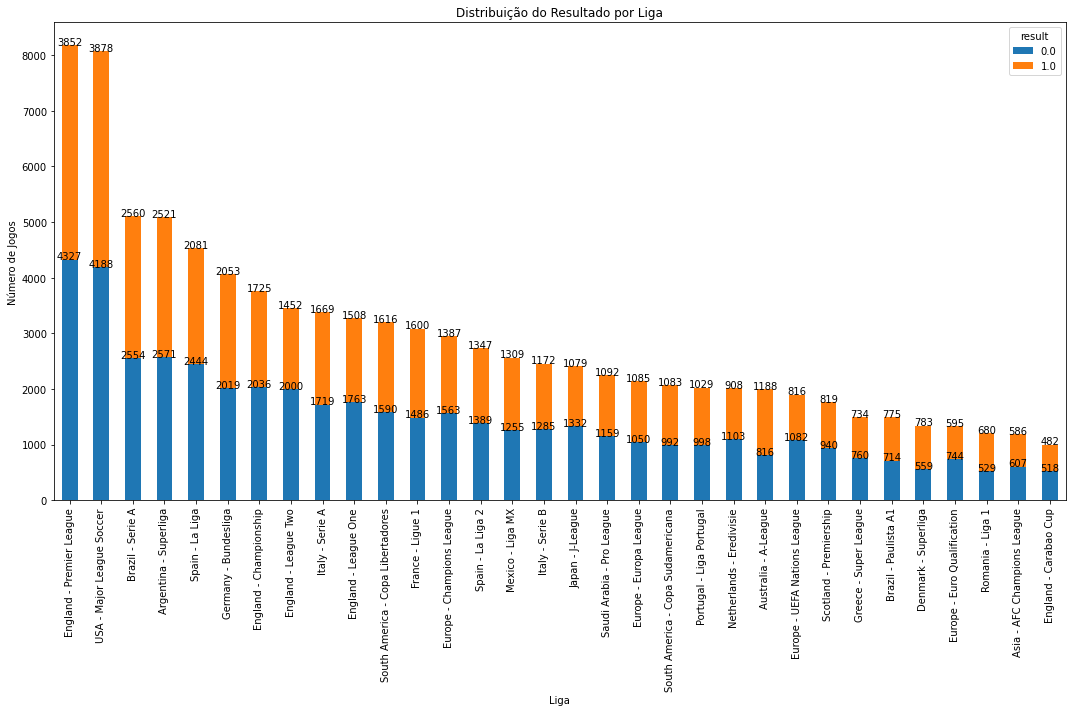

In [10]:
def filter_leagues(df, league_col, matches, min_matches=100):
    """Filtra ligas com base no número de partidas e na diversidade de resultados."""
    # Contando o número de jogos por liga
    league_game_counts = df.groupby(league_col)[matches].nunique()

    # Filtrando as ligas com pelo menos 100 jogos
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index

    # Filtrando o dataframe para incluir apenas as ligas selecionadas
    filtered_data = df[df[league_col].isin(leagues_filtered)]


    return filtered_data

def balance_data(df, result_col='result'):
    result_counts = df[result_col].value_counts()

    # Balanceando a coluna 'result' - escolhendo o menor número de instâncias entre 0 e 1
    min_count = result_counts.min()

    # Amostrando aleatoriamente linhas para cada valor de 'result'
    balanced_data = pd.concat([
        df[df[result_col] == 0].sample(min_count, random_state=42),
        df[df[result_col] == 1].sample(min_count, random_state=42)
    ])

    return balanced_data

# Aplicando as funções ao DataFrame original
print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nBalanceando dados...")
balanced_data = balance_data(df, 'result')
df = balanced_data
print("Dados balanceados:\n")
print(df['result'].value_counts())

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())
df = filtered_data

df.drop_duplicates(keep='last', inplace=True)
df.dropna(inplace=True)

league_distribution = df.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

# Iterando sobre as barras e adicionando anotações
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()


## Separação de Características, Transformação e Divisão de Dados

In [11]:
df.to_csv('data_balanced.csv', index=False, encoding='utf-8')

In [12]:
df.shape

(93556, 24)

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")


Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


# Modelos

## H2O AutoML: De Conversão de Dados a Treinamento, Carregamento e Salvamento de Modelos

In [15]:
# Inicializar o H2O
h2o.init()

# Convertendo dados do numpy para H2OFrame
X_train_h2o = h2o.H2OFrame(pd.DataFrame(X_train, columns=["col_" + str(i) for i in range(X_train.shape[1])]))
X_test_h2o = h2o.H2OFrame(pd.DataFrame(X_test, columns=["col_" + str(i) for i in range(X_test.shape[1])]))
y_train_h2o = h2o.H2OFrame(pd.DataFrame(y_train, columns=["result"]))
y_test_h2o = h2o.H2OFrame(pd.DataFrame(y_test, columns=["result"]))

# Convert Pandas DataFrame or NumPy array to H2OFrame
X_train_h2o = h2o.H2OFrame(X_train)
X_test_h2o = h2o.H2OFrame(X_test)

y_train_df = y_train.to_frame()
y_train_h2o = h2o.H2OFrame(y_train_df)
y_train_h2o['result'] = y_train_h2o['result'].asfactor()

y_test_df = y_test.to_frame()
y_test_h2o = h2o.H2OFrame(y_test_df)
y_test_h2o['result'] = y_test_h2o['result'].asfactor()

# Check the shape again
print("X_train_h2o shape:", X_train_h2o.shape)
print("y_train_h2o shape:", y_train_h2o.shape)
print("X_test_h2o shape:", X_test_h2o.shape)
print("y_test_h2o shape:", y_test_h2o.shape)

# Combine them back into one frame
train_data = X_train_h2o.cbind(y_train_h2o)
test_data = X_test_h2o.cbind(y_test_h2o)

# Identify predictors and response
x = train_data.columns

y = "result"
x.remove(y)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 17.0.8+9-LTS-211, mixed mode, sharing)
  Starting server from C:\Python310\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Pichau\AppData\Local\Temp\tmpjgqthsoj
  JVM stdout: C:\Users\Pichau\AppData\Local\Temp\tmpjgqthsoj\h2o_Pichau_started_from_python.out
  JVM stderr: C:\Users\Pichau\AppData\Local\Temp\tmpjgqthsoj\h2o_Pichau_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,America/Sao_Paulo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,3 months and 1 day
H2O_cluster_name:,H2O_from_python_Pichau_tauyd0
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.965 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
X_train_h2o shape: (74844, 50)
y_train_h2o shape: (74844, 1)
X_test_h2o shape: (18712, 50)
y_test_h2o shape: (18712, 1)


In [ ]:
# Run AutoML
aml = H2OAutoML(max_models=20, sort_metric='aucpr')
aml.train(x=x, y=y, training_frame=train_data)

# View leaderboard
lb = aml.leaderboard
print(lb)

#save the model
model_path = h2o.save_model(model=aml.leader, path="../models/", force=True)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


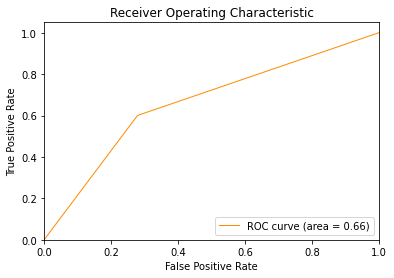

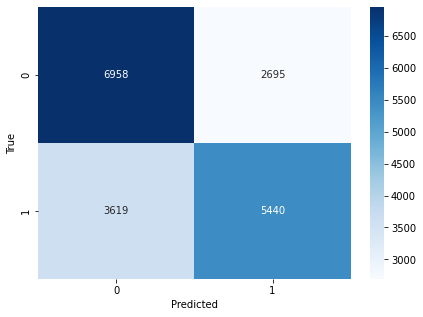

In [16]:
# h2o.init()
loaded_model = h2o.load_model("../models/model_automl")
y_pred_prob = loaded_model.predict(X_test_h2o)
y_pred = h2o.as_list(y_pred_prob)
y_pred_prob = y_pred['predict'].tolist()

# Falsos positivos, verdadeiros positivos e limiares
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Área sob a curva
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Matriz de confusão
y_pred_round = [round(value) for value in y_pred_prob]
cm = confusion_matrix(y_test.to_list(), y_pred_round)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [17]:
from sklearn.metrics import classification_report

# Certifique-se de que y_test é um array ou lista
# Se y_test for um DataFrame ou Series, converta usando .tolist() ou .values
y_test_list = y_test.tolist() if hasattr(y_test, 'tolist') else y_test

# Gerando o relatório de classificação
report = classification_report(y_test_list, y_pred_round, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.66      0.72      0.69      9653
    Classe 1       0.67      0.60      0.63      9059

    accuracy                           0.66     18712
   macro avg       0.66      0.66      0.66     18712
weighted avg       0.66      0.66      0.66     18712



### Na prática

In [18]:
df.head(1699).tail(1)['result']

36841    0.0
Name: result, dtype: float64

In [19]:
# h2o.init()
loaded_model = h2o.load_model("../models/model_automl")
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)
Xht = h2o.H2OFrame(Xht)
loaded_model.predict(Xht)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.753074,0.246926


In [20]:
# obter o valor da predição colocando o item preditor em uma lista e pegando o primeiro valor
h2o.as_list(loaded_model.predict(Xht)).loc[0, 'p1']

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


0.2469255458664504

## Treinamento e Avaliação de Modelo de Classificação Binária com Rede Neural no Keras

Iniciando a construção do modelo...
Treinando o modelo...
Epoch 1/500
1170/1170 [==============================] - 3s 2ms/step - loss: 0.6831 - accuracy: 0.5515 - recall: 0.4929 - val_loss: 0.6781 - val_accuracy: 0.5654 - val_recall: 0.6492
Epoch 2/500
1170/1170 [==============================] - 2s 1ms/step - loss: 0.6661 - accuracy: 0.5881 - recall: 0.5570 - val_loss: 0.6645 - val_accuracy: 0.5898 - val_recall: 0.6551
Epoch 3/500
1170/1170 [==============================] - 2s 1ms/step - loss: 0.6471 - accuracy: 0.6163 - recall: 0.5968 - val_loss: 0.6499 - val_accuracy: 0.6110 - val_recall: 0.5214
Epoch 4/500
1170/1170 [==============================] - 2s 1ms/step - loss: 0.6244 - accuracy: 0.6418 - recall: 0.6275 - val_loss: 0.6307 - val_accuracy: 0.6337 - val_recall: 0.6533
Epoch 5/500
1170/1170 [==============================] - 2s 1ms/step - loss: 0.6006 - accuracy: 0.6654 - recall: 0.6564 - val_loss: 0.6144 - val_accuracy: 0.6480 - val_recall: 0.6798
Epoch 6/500
1170/1170 [====

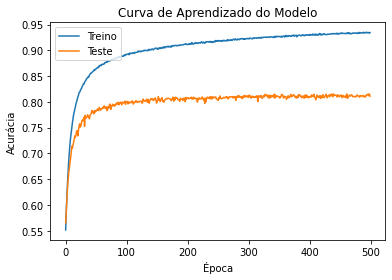

Salvando o modelo treinado...
Modelo salvo como 'model_redeht.h5'


In [26]:
print("Iniciando a construção do modelo...")
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Classificação binária

# Compilando o modelo
optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', 'Recall'])

# Configurando o Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=50)

# Treinando o modelo
print("Treinando o modelo...")
# history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Fazendo as predições
print("Fazendo predições no conjunto de teste...")
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0)

# Avaliando a acurácia do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Teste'], loc='upper left')
plt.show()

# Salvando o modelo
print("Salvando o modelo treinado...")
model.save('../models/model_redeht.h5')
print("Modelo salvo como 'model_redeht.h5'")

In [27]:
from sklearn.metrics import classification_report
import numpy as np

# Fazendo as predições no conjunto de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0).flatten()  # Converter para 0s e 1s e achatar o array

# Obtendo os rótulos verdadeiros
y_true = y_test  # Substitua com o array correto de rótulos verdadeiros do conjunto de teste

# Gerando o relatório de classificação
report = classification_report(y_true, predictions, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)


585/585 [==============================] - 0s 694us/step
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.85      0.76      0.81      9653
    Classe 1       0.77      0.86      0.82      9059

    accuracy                           0.81     18712
   macro avg       0.81      0.81      0.81     18712
weighted avg       0.82      0.81      0.81     18712



# Pytorch

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

# Definindo o modelo
class BinaryClassificationModel(nn.Module):
    def __init__(self, input_shape):
        super(BinaryClassificationModel, self).__init__()
        self.layer1 = nn.Linear(input_shape, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x

print("Iniciando a construção do modelo...")
model = BinaryClassificationModel(X_train.shape[1])

# Compilando o modelo
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Convertendo diretamente de NumPy arrays para PyTorch tensors
train_data = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_np).float())
test_data = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test_np).float())

# Criando DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Treinando o modelo
print("Treinando o modelo...")
for epoch in range(500):
    model.train()
    print(f'Epoch {epoch + 1}/500')
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.view(-1, 1))
        loss.backward()
        optimizer.step()


# Avaliando a acurácia do modelo
# Função para calcular a acurácia
def calculate_accuracy(model, data_loader):
    model.eval()  # Colocar o modelo em modo de avaliação
    correct = 0
    total = 0

    with torch.no_grad():  # Desativar o cálculo de gradientes
        for data in data_loader:
            inputs, labels = data
            outputs = model(inputs)
            predicted = (outputs.data > 0.5).float()  # Convertendo probabilidades em previsões binárias
            total += labels.size(0)
            correct += (predicted.view(-1) == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Avaliando a acurácia do modelo
train_acc = calculate_accuracy(model, train_loader)
test_acc = calculate_accuracy(model, test_loader)
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)

# Salvando o modelo
print("Salvando o modelo treinado...")
torch.save(model.state_dict(), '../models/model_redeht.pth')
print("Modelo salvo como 'model_redeht.pth'")

# carregando modelo
import torch
import torch.nn as nn

class BinaryClassificationModel(nn.Module):
    def __init__(self, input_shape):
        super(BinaryClassificationModel, self).__init__()
        self.layer1 = nn.Linear(input_shape, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))
        return x
# Crie uma instância do modelo
model = BinaryClassificationModel(input_shape=X_train.shape[1])  # Substitua X_train.shape[1] pelo tamanho correto da entrada

# Carregue os pesos salvos
model.load_state_dict(torch.load('../models/model_redeht.pth'))

# Coloque o modelo em modo de avaliação (isso é importante para desativar características como dropout, se aplicável)
model.eval()

# Exemplo fazendo uma predição
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)

X_ht = torch.from_numpy(Xht).float()

# Faça a predição
y_pred = model(X_ht)
y_pred[0][0]


Iniciando a construção do modelo...
Treinando o modelo...
Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Ep

tensor(0.0724, grad_fn=<SelectBackward0>)

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Inicialização das listas para armazenar previsões e rótulos verdadeiros
y_pred = []
y_true = []

# Iterar sobre o conjunto de teste
model.eval()  # Colocar o modelo em modo de avaliação
with torch.no_grad():  # Desativar cálculo de gradientes
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs.data > 0.5).float()  # Obter as previsões binárias

        y_pred.extend(predicted.numpy().flatten())  # Adicionar previsões à lista
        y_true.extend(labels.numpy().flatten())  # Adicionar rótulos verdadeiros à lista

# Convertendo listas para arrays NumPy
y_pred = np.array(y_pred)
y_true = np.array(y_true)

from sklearn.metrics import classification_report

# Gerando o relatório de classificação
report = classification_report(y_true, y_pred, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório
print("Relatório de Classificação:")
print(report)

Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.82      0.81      0.81      9653
    Classe 1       0.80      0.81      0.81      9059

    accuracy                           0.81     18712
   macro avg       0.81      0.81      0.81     18712
weighted avg       0.81      0.81      0.81     18712



# Arvore de decisão

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Inicializando o modelo de Árvore de Decisão
decision_tree_model = DecisionTreeClassifier()

# Treinando o modelo
print("Treinando o modelo de Árvore de Decisão...")
decision_tree_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de treinamento e teste
y_train_pred = decision_tree_model.predict(X_train)
y_test_pred = decision_tree_model.predict(X_test)

# Avaliando a acurácia do modelo
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)

# Gerando o relatório de classificação
report = classification_report(y_test, y_test_pred, target_names=['Classe 0', 'Classe 1'])
print("Relatório de Classificação:")
print(report)

# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Salvar o modelo (opcional)
import joblib
joblib.dump(decision_tree_model, '../models/model_decision_tree.pkl')
print("Modelo salvo como 'model_decision_tree.pkl'")

# lendo o modelo
import joblib
decision_tree_model = joblib.load('../models/model_decision_tree.pkl')

# Exemplo fazendo uma predição
Xht = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id']).head(1699).tail(1)
Xht = preprocessor.transform(Xht)

# Faça a predição
y_pred = decision_tree_model.predict(Xht)
y_pred[0]



Treinando o modelo de Árvore de Decisão...
Acurácia no conjunto de treinamento: 0.9961386350275239
Acurácia no conjunto de teste: 0.7734074390765284
Relatório de Classificação:
              precision    recall  f1-score   support

    Classe 0       0.80      0.74      0.77      9653
    Classe 1       0.75      0.81      0.78      9059

    accuracy                           0.77     18712
   macro avg       0.77      0.77      0.77     18712
weighted avg       0.78      0.77      0.77     18712

Matriz de Confusão:
[[7147 2506]
 [1734 7325]]
Modelo salvo como 'model_decision_tree.pkl'


0.0